# Predicting Type of Chest Pain Using Age, Serum Cholesterol Levels, Resting Blood Pressure and Maximum Heart Rate as Predictors

  Heart disease is the leading cause of death across the world, account for 1 in 6 deaths. Angina, any chest pain caused by reduced blood flow to the heart, is a warning sign for risk of heart attack and stroke. Risk factors for heart disease are thus related to the experience of anginal pain due to reduced blood flow to the heart. Elevated cholesterol levels result in plaque build up in arterial walls known as atherosclerosis. This build up causes arteries to narrow, restricting blood flow to the heart. Resting blood pressure and maximum heart rate are both directly proportional to how much blood is pumped and therefore, how much blood is flown through to the heart. 
  
  We will be using a classification model to answer the predictive question, "How can healthcare professionals use factors such as serum cholesterol levels, resting blood pressure and maximum heart rate of a patient to predict the type of chest pain the patient is experiencing?" The dataset we are using has heart disease data from Cleveland Clinic Foundation retrieved from the web. The dataset contains 14 variables including age, sex, type of chest pain, resting blood pressure, serum cholesterol, fasting blood sugar, resting ECG, maximum heart rate achieved, exercise induced angina, ST depression induced by exercise, slope of peak exercise segment, number of major vessels, defect, and angiographic disease status. It was processed from a larger data set containing 76 raw attributes but only 14 were deemed useful. 

In [154]:
#Reading dataset from web into R
library(tidyverse)
library(readr)
library(tidymodels)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(1)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland_data <- read_csv(url, col_names = c("Age", "Sex", "Chest_Pain", "Rest_BP",
                                             "Cholesterol", "Fast_BS", "Rest_ECG", 
                                             "Max_HR", "Ex_Angina", "ST_Dep", "Slope",
                                             "Vessels", "Thal", "Disease_Presence")) |>
mutate(Chest_Pain = case_when(Chest_Pain <=2 ~ 1, 
          TRUE ~2))|>
mutate(Chest_Pain = as_factor(Chest_Pain))
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Vessels, Thal
dbl (12): Age, Sex, Chest_Pain, Rest_BP, Cholesterol, Fast_BS, Rest_ECG, Max...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,Chest_Pain,Rest_BP,Cholesterol,Fast_BS,Rest_ECG,Max_HR,Ex_Angina,ST_Dep,Slope,Vessels,Thal,Disease_Presence
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,2,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,2,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,2,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,1,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,2,138,175,0,0,173,0,0.0,1,?,3.0,0


In [155]:
cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = Chest_Pain)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

head(cleveland_train)
head(cleveland_test)

Age,Sex,Chest_Pain,Rest_BP,Cholesterol,Fast_BS,Rest_ECG,Max_HR,Ex_Angina,ST_Dep,Slope,Vessels,Thal,Disease_Presence
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
41,0,1,130,204,0,2,172,0,1.4,1,0.0,3.0,0
48,1,1,110,229,0,0,168,0,1.0,3,0.0,7.0,1
49,1,1,130,266,0,0,171,0,0.6,1,0.0,3.0,0
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
58,1,1,120,284,0,2,160,0,1.8,2,0.0,3.0,1


Age,Sex,Chest_Pain,Rest_BP,Cholesterol,Fast_BS,Rest_ECG,Max_HR,Ex_Angina,ST_Dep,Slope,Vessels,Thal,Disease_Presence
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
37,1,2,130,250,0,0,187,0,3.5,3,0.0,3.0,0
56,1,1,120,236,0,0,178,0,0.8,1,0.0,3.0,0
53,1,2,140,203,1,2,155,1,3.1,3,0.0,7.0,1
57,1,2,140,192,0,0,148,0,0.4,2,0.0,6.0,0
56,0,1,140,294,0,2,153,0,1.3,2,0.0,3.0,0
44,1,1,120,263,0,0,173,0,0.0,1,0.0,7.0,0


In [156]:
#There are not any rows with missing data

#Table 1 Count and percentage for each category of chestpain
num_obs <- nrow(cleveland_train)
cleveland_train|>
group_by(Chest_Pain)|>
summarize(count = n(), percentage = n()/num_obs*100)

Chest_Pain,count,percentage
<fct>,<int>,<dbl>
1,54,23.89381
2,172,76.10619


In [157]:
#Table 2 mean values for the predictor of each category of chestpain
cleveland_train|>
group_by(Chest_Pain)|>
summarize(Average_Age = mean(Age), Average_Cholesterol = mean(Cholesterol), average_Rest_BP = mean(Rest_BP), average_Max_HR = mean(Max_HR))

Chest_Pain,Average_Age,Average_Cholesterol,average_Rest_BP,average_Max_HR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,52.72222,247.1296,134.6111,162.0185
2,54.86047,249.1744,131.0349,145.2616


In [158]:
#Visualization of cholesterol and age
age_choles <- cleveland_train |>
    ggplot(aes(x = Age, y = Cholesterol, color = Chest_Pain))+
    geom_point()+
    labs(x = "Age (years)", y = "Cholesterol (mg/dL)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen"))+
theme(text = element_text(size = 18))

In [159]:
#Visualization of age with Resting Blood Pressure
age_bp <- cleveland_train |>
    ggplot(aes(x = Age, y = Rest_BP, color = Chest_Pain))+
    geom_point()+
    labs(x = "Age (years)", y = "Rest Blood Pressure (mm Hg) ", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen"))+
theme(text = element_text(size = 18))

In [160]:
#Visualization between age and max heart rate achieve
age_hr <- cleveland_train |>
    ggplot(aes(x = Age, y = Max_HR, color = Chest_Pain))+
    geom_point()+
    labs(x = "Age (years)", y = "Maximum Heart Rate Achieved (bpm)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen"))+
theme(text = element_text(size = 18))

In [161]:
#Visualization of Cholesterol with Resting Blood Pressure
choles_bp <- cleveland_train |>
    ggplot(aes(x = Cholesterol, y = Rest_BP, color = Chest_Pain))+
    geom_point()+
    labs(x ="Cholesterol (mg/dL)", y = "Rest Blood Pressure (mm Hg)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen"))+
theme(text = element_text(size = 18))

In [162]:
#Visualization between cholesterol and max heart rate achieve
choles_hr <- cleveland_train |>
    ggplot(aes(x = Cholesterol, y = Max_HR, color = Chest_Pain))+
    geom_point()+
    labs(x = "Cholesterol (mg/dL)", y = "Maximum Heart Rate Achieved (bpm)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen"))+
theme(text = element_text(size = 18))

In [163]:
#Visualization between Resting blood pressure and max heart rate achieve
bp_hr <- cleveland_train |>
    ggplot(aes(x = Rest_BP, y = Max_HR, color = Chest_Pain))+
    geom_point()+
    labs(x = "Rest Blood Pressure (mm Hg)", y = "Maximum Heart Rate Achieved (bpm)", color = "Types of Chest Pain")+
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"),
                        values = c("orange2", "steelblue", "darkmagenta", "forestgreen"))+
theme(text = element_text(size = 18))

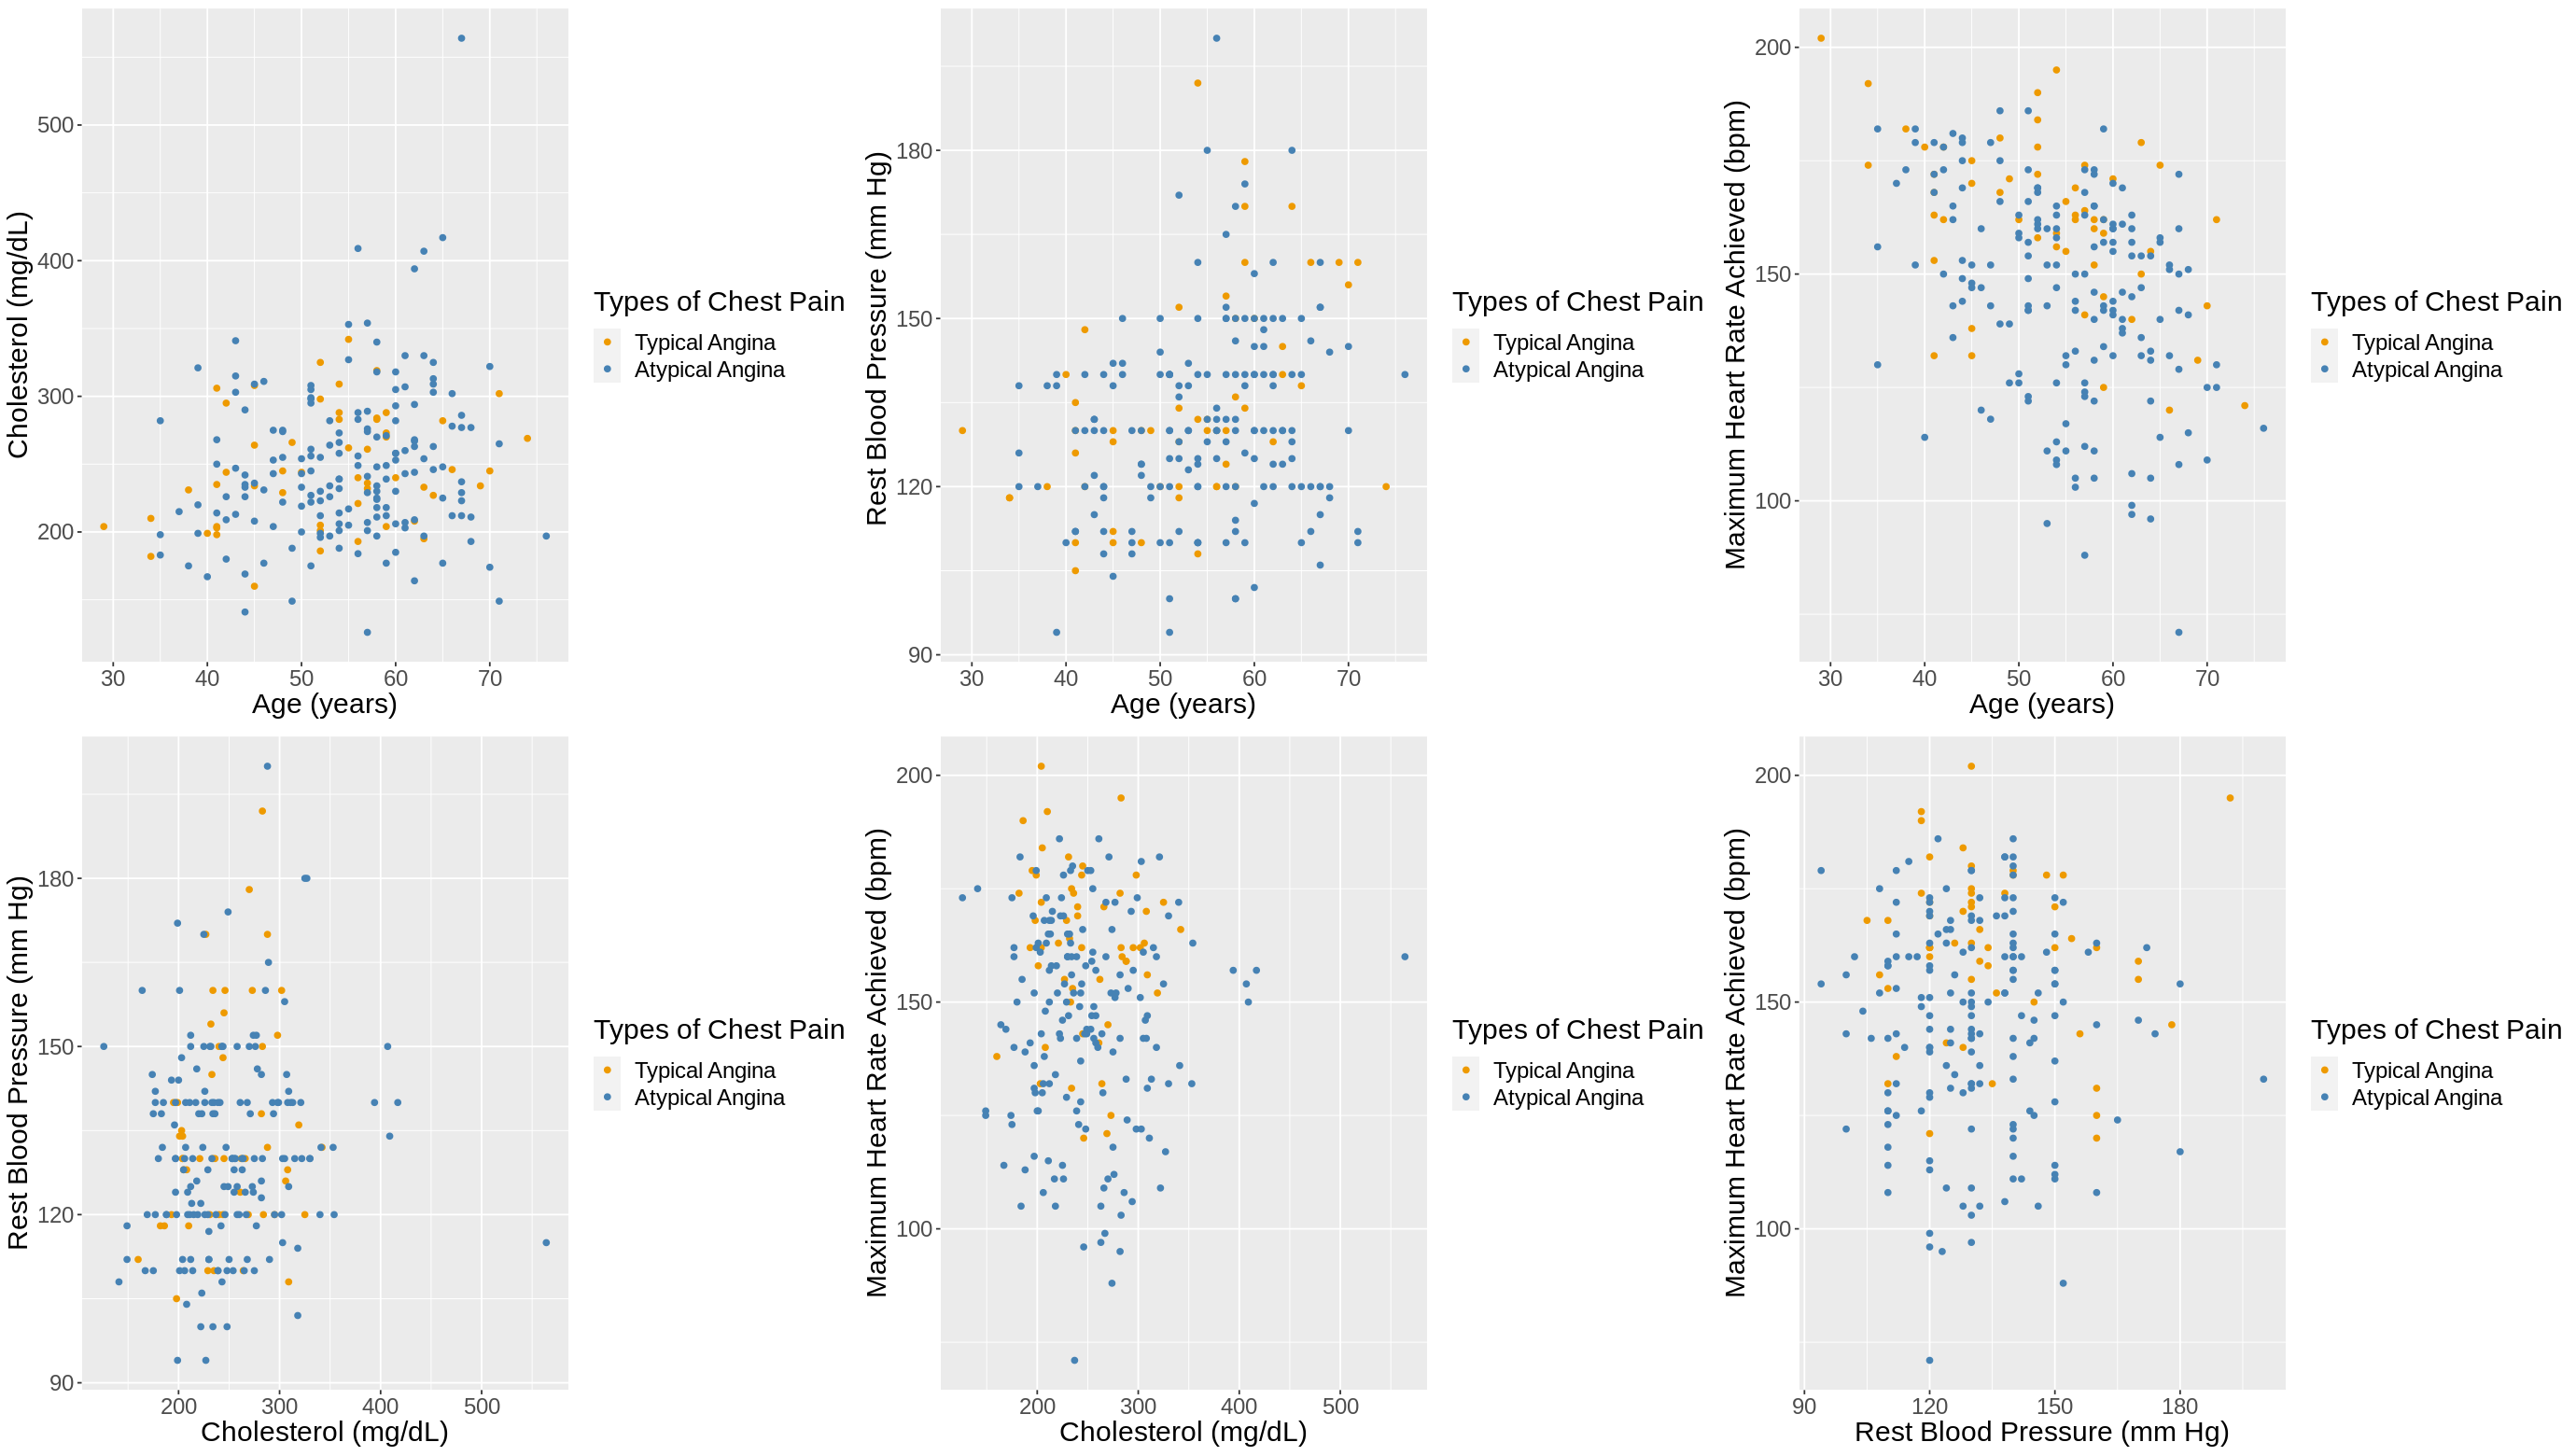

In [164]:
# All visualizations
options(repr.plot.width = 23, repr.plot.height = 13)
plot_grid(age_choles, age_bp, age_hr, choles_bp, choles_hr, bp_hr, ncol = 3) 


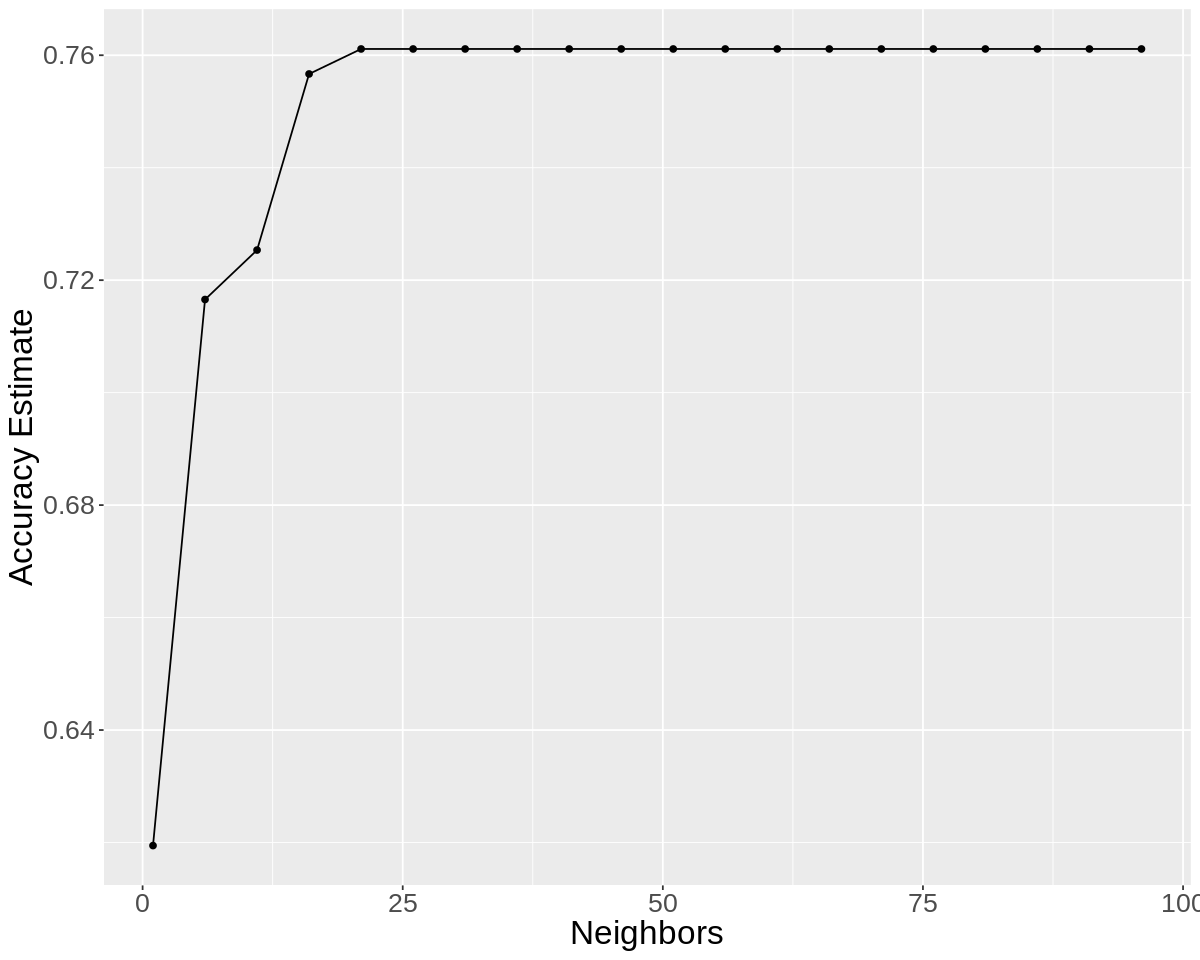

In [165]:
#Split up the data for cross validation
chest_pain_vfold <- vfold_cv(cleveland_train, v = 5, strata = Chest_Pain) 

#Create a recipe
chest_pain_recipe <- recipe(Chest_Pain ~ Cholesterol + Age + Rest_BP + Max_HR , 
                        data = cleveland_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

#create model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#create the k values
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#Add the recipe and model to the workflow and perform cross validation
knn_results <- workflow() |>
  add_recipe(chest_pain_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = chest_pain_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

#Pick the k value that is suitable by plotting the accuracy vs k
options(repr.plot.width = 10, repr.plot.height = 8)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 20))
accuracy_vs_k


In [166]:
#Make a new model specification for the best K value
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

#Retrain the classifier
knn_fit <- workflow() |>
    add_recipe(chest_pain_recipe) |>
    add_model(knn_spec) |>
    fit(data = cleveland_train)

#Evaluate the estimated accuracy of the classifier
chest_pain_test_predictions <- predict(knn_fit, cleveland_test) |>
    bind_cols(cleveland_test)

#Find the accuracy
chest_pain_test_predictions |>
    metrics(truth = Chest_Pain, estimate = .pred_class) |>
    filter(.metric == "accuracy")

#Find the confusion matrix
confusion <- chest_pain_test_predictions |>
    conf_mat(truth = Chest_Pain, estimate = .pred_class)
confusion

               

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7402597


          Truth
Prediction  1  2
         1  0  1
         2 19 57

### Methods

Classification is the method of predicting which category a new observation falls into depending on its other variables (predictors). For our project, we will be analysing data by training a K-nearest neighbour classifier model with a subset of the data and using this model to predict what type of chest pain the patient is experiencing. Classification will be a useful methodology as we can assign multiple variables to be used as predictors, assign the same weight to each variable, and get a predicted category. There are 14 different variables in the cleveland_data set which all provide information on factors associated with heart disease. We have chosen 4 variables that we deem to be the most useful in predicting type of chest pain. Diagnosing chest pain is a complex process as there are numerous factors that impact the patient's experience. Therefore, we have chosen multiple predictors in order to acheive a more accurate analysis of the factors causing chest pain. The required variables used in our data analysis will be as follows:
- Predictors: Age (years), Serum cholesterol levels (mg/dl), Rest Blood Pressure (mm Hg) and Maximum Heart Rate Achieved (bpm)
              
- Category to predict: Type of Chest Pain (eg: 1, 2, 3, 4)

We have chosen to plot each permutation of the four variables as scatter plots and colored by the type of chest pain. This allows us to visualize any preliminary relationships of individual predictors with type of chest pain. For example, from the above plots it appears as though higher maximum heart rate may be correlated with typical angina. We will also plot distribution graphs to visualize the distribution of each variable for the types of chest pain. From this point, we will combine all of the predictors into the classifiying model, use cross-validation, tune it, train the model using our training data, and lastly use the final model to predict the type of chest pain for the data in our testing set. 

### Expected Outcomes and Significance

We would expect to predict the type of chest pain given the values of each predictors. If we predict a value of 1 in an analysis it corresponds to typical angina, a value of 2 corresponds to atypical angina, a value of 3 corresponds to nonanginal pain, and a value of 4 corresponds to asymptomatic. In general, we expect to find that higher values of each predictor relate to typical and atypical angina pain while lower values of each predictor relate to non-anginal and asymptomatic. 

The impact of these findings could help doctors predict which patients are at a higher risk for heart attacks and strokes. Cholesterol, age, resting blood pressure and maxium heart rate are easily measurable factors that a general care physician could measure in typical check ups. If heart attack and stroke risk can be determined from these factors, doctors can help their patients implement preventative measures prior to the health incidents' occurring. Due to the severity of heart disease, it is critical that doctors are able to provide preventative treatment as opposed to reactive treatment. Notably, 12% of patients who experience heart attacks pass away as a result of it. The ability to predict which patients are at a higher risk could save hundreds of thousands of lives each year.

Our data exploration is centered on finding the levels of each variable that predict the different types of chest pain and thus future questions would follow this same context. For example, what is the threshold serum cholesterol level where patients experiencing chest pain will most likely be diagnosed with angina? Another question is discovering the age ranges that are at risk of each type of chest pain. For example, what age group is most at risk for anginal chest pain? Due to the nature of anginal pain corresponding with heart disease, these questions are focussed on assesing the risks of anginal pain rather than assessing the factors of other types of chest pain.

